In [ ]:
# import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib_venn as venn

In [ ]:
# read in data for enslaved people tab
enslaved_tab = pd.read_csv('Census Charlestown 1775 05-14-24 - Enslaved people.csv')

# clean up formatting
enslaved_tab.columns = ['Year of Record', 'Total People Enslaved in Record', '# Male', '# Female', '# Black',
                        '# Native', 'Name and/or Description', 'Enslaver Last Name', 'Enslaver First Name',
                        'Town', 'Unique ID']
enslaved_tab = enslaved_tab.drop([0])

# convert some columns from nan to 0
enslaved_tab['# Male'] = enslaved_tab['# Male'].fillna(0)
enslaved_tab['# Female'] = enslaved_tab['# Female'].fillna(0)
enslaved_tab['# Native'] = enslaved_tab['# Native'].fillna(0)

# convert datatypes
enslaved_tab['Year of Record'] = enslaved_tab['Year of Record'].astype(int)
enslaved_tab['Total People Enslaved in Record'] = enslaved_tab['Total People Enslaved in Record'].astype(int)
enslaved_tab['# Male'] = enslaved_tab['# Male'].astype(int)
enslaved_tab['# Female'] = enslaved_tab['# Female'].astype(int)
enslaved_tab['# Black'] = enslaved_tab['# Black'].astype(int)
enslaved_tab['# Native'] = enslaved_tab['# Native'].astype(int)

enslaved_tab

FileNotFoundError: [Errno 2] No such file or directory: 'Census Charlestown 1775 05-14-24 - Enslaved people.csv'

Text(8.65, 25, '*28 enslaved people did not \nhave an enslaver listed.')

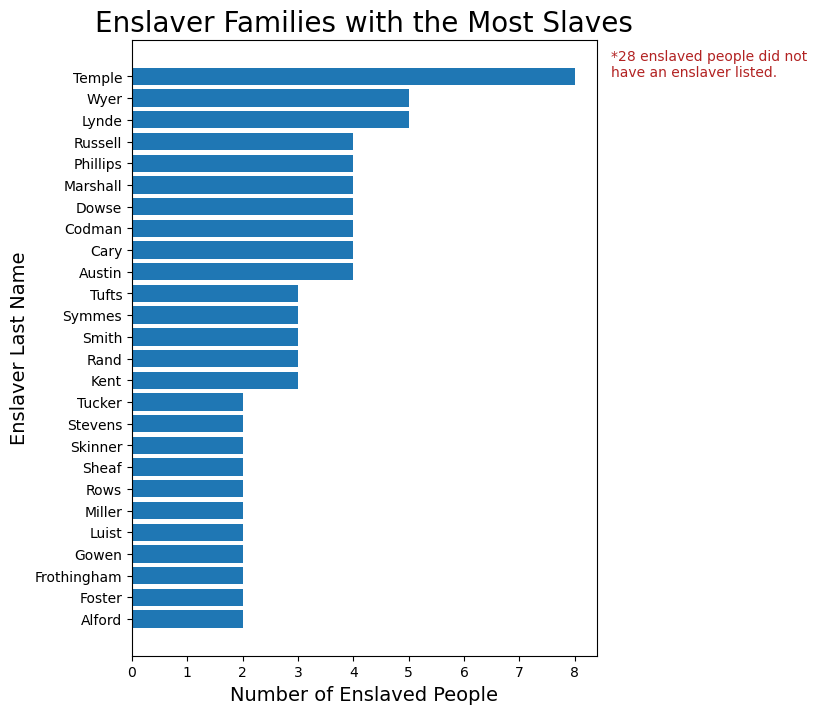

In [ ]:
# get number of enslaved people by enslaver family
enslaver_names_dict = {}
for i in range(len(enslaved_tab['Enslaver Last Name'])):
    if enslaved_tab['Enslaver Last Name'].iloc[i] in enslaver_names_dict.keys():
        enslaver_names_dict[enslaved_tab['Enslaver Last Name'].iloc[i]] += 1
    else:
        enslaver_names_dict[enslaved_tab['Enslaver Last Name'].iloc[i]] = 1

# make list of enslaver families that enslaved more than one person
enslaver_names_lst = []
for key, value in enslaver_names_dict.items():
    if value > 1:
        enslaver_names_lst.append((key, value))

# sort the list from greatest to least
enslaver_names_lst.sort(key=lambda tup: tup[1])

# make separate lists for x and y
enslaver_names_x = []
enslaver_names_y = []
for name in enslaver_names_lst:

    # skip nan values
    if enslaver_names_lst.index(name) == 26:
        pass

    else:
        enslaver_names_x.append(name[0])
        enslaver_names_y.append(name[1])

# plot the data
plt.figure(figsize=(6, 8))
plt.barh(enslaver_names_x, enslaver_names_y)
plt.title('Enslaver Families with the Most Slaves', fontsize=20)
plt.xlabel('Number of Enslaved People', fontsize=14)
plt.ylabel('Enslaver Last Name', fontsize=14)
plt.text(8.65, 25, '*28 enslaved people did not \nhave an enslaver listed.', color='firebrick')

In [ ]:
import altair as alt


In [ ]:
# filter data for just families with more than one slave
multi_slaves_lst = []

for i in range(len(enslaved_tab['Enslaver Last Name'])):
    if enslaved_tab['Enslaver Last Name'].iloc[i] in enslaver_names_x:
        multi_slaves_lst.append(enslaved_tab.iloc[i])

multi_slaves = pd.DataFrame(multi_slaves_lst, columns=['Year of Record', 'Total People Enslaved in Record', '# Male', '# Female', '# Black',
                        '# Native', 'Name and/or Description', 'Enslaver Last Name', 'Enslaver First Name',
                        'Town', 'Unique ID'])

In [ ]:
def gender(person):
    if person['# Female'] > 0:
        return 'Female'
    else:
        return 'Male'

# Add a new column indicating if the person is male or female
multi_slaves['Gender'] = multi_slaves.apply(gender, axis=1)

In [ ]:
multi_slaves.head()

,Year of Record,Total People Enslaved in Record,# Male,# Female,# Black,# Native,Name and/or Description,Enslaver Last Name,Enslaver First Name,Town,Unique ID,Is Woman,Gender
1,1741,1,0,1,1,0,Coelia,Alford,Captain,Charlestown,ID_1,True,Female
2,1751,1,0,1,1,0,Phillis,Alford,John,Charlestown,ID_2,True,Female
5,1749,1,0,1,1,0,Belinda,Austin,John,Charlestown,ID_5,True,Female
6,1721,1,1,0,1,0,Cezar,Austin,Ebenr.,Charlestown,ID_6,False,Male
7,1751,1,0,1,1,0,Grace,Austin,Ebenezer,Charlestown,ID_7,True,Female


In [ ]:
# bar chart to be linked
brush = alt.selection_interval(empty=False)

base = (
    alt.Chart(data=multi_slaves)
    .transform_aggregate(count_="count()", groupby=["Enslaver Last Name", "Enslaver First Name"])
    .transform_stack(
        stack="count_",
        as_=["stack_count_Enslaver_Last_Name1", "stack_count_Enslaver_Last_Name2"],
        offset="normalize",
        sort=[alt.SortField("Enslaver Last Name", "ascending")],
        groupby=[],
    )
    .transform_window(
        x="min(stack_count_Enslaver_Last_Name1)",
        x2="max(stack_count_Enslaver_Last_Name2)",
        rank_First="dense_rank()",
        distinct_First="distinct(Enslaver First Name)",
        groupby=["Enslaver Last Name"],
        frame=[None, None],
        sort=[alt.SortField("Enslaver First Name", "ascending")],
    )
    .transform_window(
        rank_Last="dense_rank()",
        frame=[None, None],
        sort=[alt.SortField("Enslaver Last Name", "ascending")],
    )
    .transform_stack(
        stack="count_",
        groupby=["Enslaver Last Name"],
        as_=["y", "y2"],
        offset="normalize",
        sort=[alt.SortField("Enslaver First Name", "ascending")],
    )
    .transform_calculate(
        ny="datum.y + (datum.rank_First - 1) * datum.distinct_First * 0.01 / 3",
        ny2="datum.y2 + (datum.rank_First - 1) * datum.distinct_First * 0.01 / 3",
        nx="datum.x + (datum.rank_Last - 1) * 0.01",
        nx2="datum.x2 + (datum.rank_Last - 1) * 0.01",
        xc="(datum.nx+datum.nx2)/2",
        yc="(datum.ny+datum.ny2)/2",
    ).properties(
        height=300,
        width=2000
    )
)




rect = base.mark_rect().encode(
    x=alt.X("nx:Q").axis(None),
    x2="nx2",
    y="ny:Q",
    y2="ny2",
    color=alt.Color("Enslaver Last Name:N").legend(None),
    opacity=alt.Opacity("Enslaver First Name:N").legend(None),
    tooltip=["Enslaver Last Name:N", "Enslaver First Name:Q"],
)


text = base.mark_text(baseline="middle").encode(
    alt.X("xc:Q").axis(None),
    alt.Y("yc:Q").title("Enslaver First Name"),
    text="Enslaver First Name:N"
)

mosaic = rect + text

mosaic = mosaic.add_params(brush)

origin_labels = base.mark_text(baseline="middle", align="center").encode(
    alt.X("min(xc):Q").title("Enslaver Last Name").axis(orient="top"),
    alt.Color("Enslaver Last Name").legend(None),
    text="Enslaver Last Name",
)

(
    (origin_labels & mosaic)
    .resolve_scale(x="shared")
    .configure_view(stroke="")
    .configure_concat(spacing=10)
    .configure_axis(domain=False, ticks=False, labels=False, grid=False)
)

family_bar = alt.Chart(data=multi_slaves).transform_aggregate(count_="count()",
                                                              groupby=["Enslaver Last Name",
                                                                       "Enslaver First Name",
                                                                       "Name and/or Description",
                                                                      "Gender"]).transform_stack(
        stack="count_",
        as_=["stack_count_Enslaver_Last_Name1", "stack_count_Enslaver_Last_Name2"],
        offset="normalize",
        sort=[alt.SortField("Enslaver Last Name", "ascending")],
        groupby=[],
    ).transform_window(
        x="min(stack_count_Enslaver_Last_Name1)",
        x2="max(stack_count_Enslaver_Last_Name2)",
        rank_First="dense_rank()",
        distinct_First="distinct(Enslaver First Name)",
        groupby=["Enslaver Last Name"],
        frame=[None, None],
        sort=[alt.SortField("Enslaver First Name", "ascending")],
    ).transform_window(
        rank_Last="dense_rank()",
        frame=[None, None],
        sort=[alt.SortField("Enslaver Last Name", "ascending")],
    ).transform_stack(
        stack="count_",
        groupby=["Enslaver Last Name"],
        as_=["y", "y2"],
        offset="normalize",
        sort=[alt.SortField("Enslaver First Name", "ascending")],
    ).transform_calculate(
        ny="datum.y + (datum.rank_First - 1) * datum.distinct_First * 0.01 / 3",
        ny2="datum.y2 + (datum.rank_First - 1) * datum.distinct_First * 0.01 / 3",
        nx="datum.x + (datum.rank_Last - 1) * 0.01",
        nx2="datum.x2 + (datum.rank_Last - 1) * 0.01",
        xc="(datum.nx+datum.nx2)/2",
        yc="(datum.ny+datum.ny2)/2",
    ).mark_bar().encode(
    x=alt.X('Gender:N', axis=alt.Axis(labelAngle=0)),
    y='Name and/or Description:N',
    color = 'Enslaver Last Name:N',
).transform_filter(brush).properties(
        height=500,
        width=200
)


(mosaic & family_bar)

alt.VConcatChart(...)